## Read the data first

In [ ]:
from pathlib import Path
from nb_utils import read_commits, SAFETENSORS_RELEASE_DATE
import pandas as pd

df = read_commits()

# When was the first safetensors release made
reference_date = SAFETENSORS_RELEASE_DATE

# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']

# Group by elapsed days to count files modified on each date
files_modified_by_elapsed_days = df_safetensors['elapsed_days'].value_counts().sort_index()

# Group by date and count the number of files modified on that date
files_modified_by_date = df_safetensors['date'].value_counts().sort_index()


In [27]:
# finds all tows with elapsed_days = 551
df_safetensors[df_safetensors['elapsed_days'] == 551]
# check how many of them were made by the SFConvertbot
df_safetensors[df_safetensors['elapsed_days'] == 551]['message'].str.contains('Adding `safetensors` variant of this model').sum()

# find the rows not made by the SFConvertbot
# df_safetensors[df_safetensors['elapsed_days'] == 551][~df_safetensors['message'].str.contains('Safetensors convertbot')]
files_modified_by_elapsed_days

elapsed_days
6      3
27     1
52     2
54     7
152    2
      ..
674    1
680    7
691    1
703    1
733    2
Name: count, Length: 149, dtype: int64

## RQ1 How long it took developers to adopt safetensors after its first release?

Goal is to check when safetensors was first used in each studied repository.    

### Analysis 1: Number of elapsed days since the release of safetensors
Compute the number of model files added/changed over time since the release of safetensors.

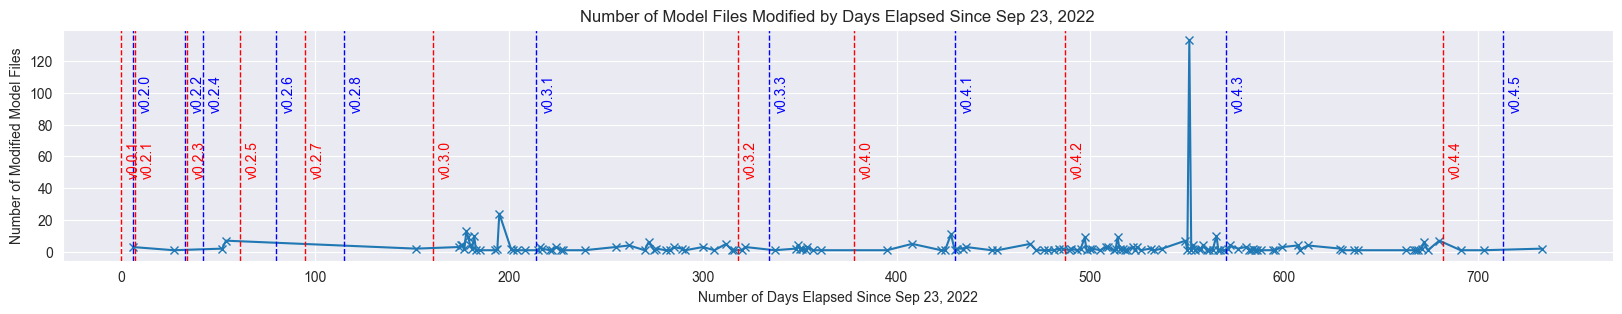

In [13]:
import matplotlib.pyplot as plt
from nb_utils import get_safetensors_releases, SAFETENSORS_RELEASE_DATE

# Plotting
plt.figure(figsize=(20,3))
plt.plot(files_modified_by_elapsed_days.index, files_modified_by_elapsed_days.values, marker='x', linestyle='-')
plt.xlabel("Number of Days Elapsed Since Sep 23, 2022")
plt.ylabel("Number of Modified Model Files")
plt.title("Number of Model Files Modified by Days Elapsed Since Sep 23, 2022")
plt.grid(True)


df_releases  = get_safetensors_releases()

#  add vertical lines for each release date with labels
position = 0.5
for day, label in df_releases[['date', 'tag']].values:
    # plt.axvline(x=day, color='red', linestyle='--', linewidth=1)
    diff = (day - reference_date).days
    color = 'red' if position == 0.5 else 'blue'
    plt.axvline(x=diff, color=color, linestyle='--', linewidth=1)
    plt.text(diff + 3, plt.ylim()[1] * position, label, color=color, rotation=90, verticalalignment='top')
    position = 0.8 if position == 0.5 else 0.5

# Save the plot as a PDF file
plt.savefig(Path('../../results/rq1_analysis.pdf'), format="pdf", bbox_inches="tight")

plt.show()


### Analysis 2: Number of elapsed days since safetensors first appearead in a repo


Number of analyzed repos:  1028
Number of repos without safetensors: 612
Number of repos using safe tensors 416
(min, quartile2, median, quartile4, max) (6, 224.0, 512.5, 551.0, 733)


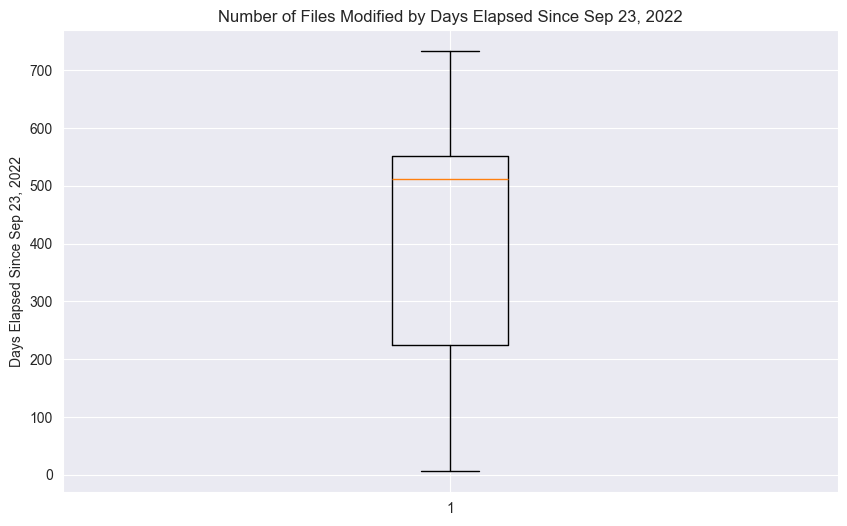

In [14]:
import matplotlib.pyplot as plt

# find the lowest number of elapsed days per unique repo_url
df_safetensors_first_appearance = df_safetensors.groupby('repo_url')['elapsed_days'].min()
df_safetensors_first_appearance = df_safetensors_first_appearance.reset_index()


min = df_safetensors_first_appearance['elapsed_days'].min()
max = df_safetensors_first_appearance['elapsed_days'].max()
median = df_safetensors_first_appearance['elapsed_days'].median()
quartile2 = df_safetensors_first_appearance['elapsed_days'].quantile(0.25)
quartile4 = df_safetensors_first_appearance['elapsed_days'].quantile(0.75)
# count number of repos wihout safetensors
print("Number of analyzed repos: ", len(df['repo_url'].unique()))
print(f"Number of repos without safetensors: {len(df['repo_url'].unique()) - len(df_safetensors_first_appearance)}")
print("Number of repos using safe tensors", len(df_safetensors_first_appearance))
print("(min, quartile2, median, quartile4, max)",(min, quartile2, median, quartile4, max))

# show box plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_safetensors_first_appearance['elapsed_days'])
plt.ylabel("Days Elapsed Since Sep 23, 2022")
plt.title("Number of Files Modified by Days Elapsed Since Sep 23, 2022")
plt.grid(True)
plt.show()



### Analysis 3: Calendar View

#### Attempt 1

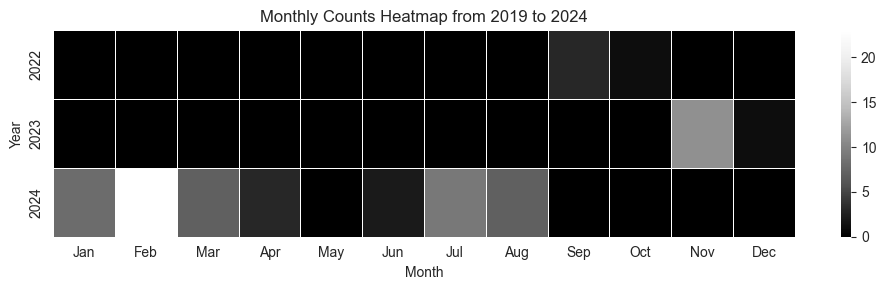

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_safetensors2 = df_safetensors.copy()

# exclude rows with message containing 'Adding `safetensors` variant of this model'
df_safetensors2 = df_safetensors2[~df_safetensors2['message'].str.contains('Adding `safetensors` variant of this model')]

# Assuming 'df_safetensors2' is your existing DataFrame
# Convert the 'date' column to datetime, handling any errors
df_safetensors2["date"] = pd.to_datetime(df_safetensors2["date"], errors="coerce")

# Drop rows where 'date' could not be parsed
df_safetensors2 = df_safetensors2.dropna(subset=["date"])

# Resample to daily frequency, counting occurrences for each day
df_daily = df_safetensors2.resample("D", on="date").size().reset_index(name='count')

# Resample again to monthly frequency, summing the counts for each month
df_monthly = df_daily.resample("ME", on="date").sum()

# Extract year and month from the index
df_monthly["year"] = df_monthly.index.year
df_monthly["month"] = df_monthly.index.month

# Pivot table with years as rows and months as columns
pivot_table = df_monthly.pivot_table(
    values="count",
    index="year",
    columns="month",
    aggfunc="sum"
).fillna(0)



# Set up the plot size for better readability
plt.figure(figsize=(10, 3))

# Create a heatmap with Seaborn
sns.heatmap(
    pivot_table,
    cmap="Greys_r",  # Use shades of black, darker indicates higher counts
    linewidths=0.5,
    linecolor='white',
    cbar=True,
    xticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    yticklabels=True  # Display year labels
)

# Add titles and labels
plt.title("Monthly Counts Heatmap from 2019 to 2024")
plt.xlabel("Month")
plt.ylabel("Year")

# Display the heatmap
plt.tight_layout()
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df_daily' contains 'date' and 'count'
# Create a pivot table for daily counts with year as rows and day of the year as columns
df_daily["day_of_year"] = df_daily["date"].dt.dayofyear
df_daily["year"] = df_daily["date"].dt.year

# Create the pivot table where rows are years and columns are days of the year
pivot_table_daily = df_daily.pivot_table(
    values="count",
    index="year",
    columns="day_of_year",
    fill_value=0
)

# Set up the plot size
plt.figure(figsize=(20, 3))

# Create the heatmap
sns.heatmap(
    pivot_table_daily,
    cmap="Greys_r",  # Shades of black, darker for higher counts
    linewidths=0.1,
    linecolor='white',
    cbar=True,
    xticklabels=30  # Show every 30th day for better readability
)

# Add titles and labels
plt.title("Daily Counts Heatmap (2022-2024)")
plt.xlabel("Day of Year")
plt.ylabel("Year")

# Display the heatmap
plt.tight_layout()
plt.show()


In [ ]:

df["date"] = pd.to_datetime(df["date"]) # Convert 'date' column to datetime format
df_monthly = df.resample("M", on='date').sum()  # Use 'on' parameter to specify the date column
df_monthly["year"] = df_monthly.index.year
df_monthly["month"] = df_monthly.index.month
df = files_modified_by_date.to_frame(name='count').reset_index()  # Convert Series to DataFrame and reset index
df.columns = ['date', 'count']  # Ensure the headers are 'date' and 'count'

pivot_table = df_monthly.pivot_table(
    values="count",
    index="year",
    columns="month",
    aggfunc="sum"
).fillna(0)


# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_table,
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='white',
    cbar=True,
    xticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    yticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
)

plt.title("Calendar Heatmap of Library Adoption")
plt.xlabel("Month")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    "date": [
        "2024-01-01", "2024-01-05", "2024-01-10",
        "2024-02-01", "2024-02-05", "2024-03-01",
        "2024-03-15", "2024-03-20", "2024-04-01",
    ],
    "adoptions": [5, 2, 3, 7, 1, 4, 6, 8, 2]
}



df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])



# df = files_modified_by_date.to_frame(name='count').reset_index()  # Convert Series to DataFrame and reset index
# df.columns = ['date', 'count']  # Ensure the headers are 'date' and 'count'

# Create a new DataFrame with the counts per day
df.set_index("date", inplace=True)
df = df.resample("D").sum().fillna(0)  # Resample to daily frequency, filling missing days with zero

# Extract month and day of the week
df["month"] = df.index.month
df["day"] = df.index.day
df["day_of_week"] = df.index.dayofweek

# Create a pivot table for the heatmap
pivot_table = df.pivot_table(
    values="adoptions",
    index="day_of_week",
    columns="month",
    aggfunc="sum"
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_table,
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='white',
    cbar=True,
    xticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    yticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
)

plt.title("Calendar Heatmap of Library Adoption")
plt.xlabel("Month")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Create sample data
date_range = pd.date_range(start="2019-01-01", end="2024-12-31")
data = {
    "date": date_range,
    "adoptions": np.random.randint(0, 10, size=len(date_range))
}

df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])


# Set date as the index
df.set_index("date", inplace=True)
df = df.resample("D").sum().fillna(0)  # Resample to daily frequency, filling missing days with zero


df["year"] = df.index.year
df["month"] = df.index.month
df["day_of_week"] = df.index.dayofweek
df["day"] = df.index.day


# Pivot table with multi-index for year and month
pivot_table = df.pivot_table(
    values="adoptions",
    index=["day_of_week", "day"],
    columns=["year", "month"],
    aggfunc="sum"
)


import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(24, 12))  # Adjust size for better visibility
sns.heatmap(
    pivot_table,
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='white',
    cbar=True,
    xticklabels=True,  # Shows year and month labels
    yticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
)

plt.title("Calendar Heatmap of Library Adoption from 2019 to 2024")
plt.xlabel("Year-Month")
plt.ylabel("Day of the Week")
plt.tight_layout()
plt.show()


In [94]:
import pandas as pd
import numpy as np

# Create a date range from 2019-01-01 to 2024-12-31
date_range = pd.date_range(start="2019-01-01", end="2024-12-31", freq='D')
data = {
    "date": date_range,
    "adoptions": np.random.randint(0, 10, size=len(date_range))  # Replace with your adoption data
}





df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])
# Set the date as the index
df.set_index("date", inplace=True)

# Aggregate by month, summing the adoption values
df_monthly = df.resample("M").sum()  # Resample to monthly frequency
df_monthly["year"] = df_monthly.index.year
df_monthly["month"] = df_monthly.index.month
# Pivot table with years as rows and months as columns
pivot_table = df_monthly.pivot_table(
    values="adoptions",
    index="year",
    columns="month",
    aggfunc="sum"
).fillna(0)
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table,
    # cmap="YlGnBu",
    cmap="Greys_r",
    linewidths=0.5,
    linecolor='white',
    cbar=True,
    xticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    yticklabels=True  # Display year labels
)

plt.title("Monthly Adoption Heatmap from 2019 to 2024")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


/var/folders/cw/6strsjk52m3f3jfpzgyc4ktc0000gq/T/ipykernel_46292/1320248051.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample("M").sum()  # Resample to monthly frequency


ModuleNotFoundError: No module named 'seaborn'